In [4]:
%load_ext autoreload
%autoreload 2

import poisson_atac as patac
import scanpy as sc

import scipy.sparse
from pytorch_lightning.loggers import WandbLogger
import wandb
import numpy as np
import pytorch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'torch'

In [ ]:
adata = patac.data.load_neurips()

sc.pl.umap(adata, color = "cell_type")

# Run scvi on "corrected" ATAC with poisson loss

In [ ]:
import scvi

atac = adata[adata.obs.batch == 's1d1'].copy()

atac.layers["counts"].max()

In [ ]:
def compute_embedding(adata, X_emb):      
    adata.obsm['X_emb'] = X_emb
    
    if 'X_umap' in adata.obsm.keys():
        adata.obsm.pop('X_umap')
    if 'umap' in adata.obsm.keys():
        adata.obsm.pop('umap')  
    if 'neighbors' in adata.uns.keys():
        adata.uns.pop('neighbors')
    sc.pp.neighbors(adata, use_rep='X_emb')
    sc.tl.umap(adata)

In [2]:
! pwd

/storage/groups/ml01/code/laura.martens/atac_poisson_study/notebooks


# SCVI

In [3]:
scvi.model.SCVI.setup_anndata(atac, layer="counts")

NameError: name 'scvi' is not defined

In [ ]:
model = scvi.model.SCVI(adata=atac, gene_likelihood="poisson", n_latent=18, n_hidden=341, use_layer_norm="both", use_batch_norm="none")

In [25]:
model.module

VAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=116490, out_features=341, bias=True)
          (1): None
          (2): LayerNorm((341,), eps=1e-05, elementwise_affine=False)
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=341, out_features=18, bias=True)
    (var_encoder): Linear(in_features=341, out_features=18, bias=True)
  )
  (l_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=116490, out_features=341, bias=True)
          (1): None
          (2): LayerNorm((341,), eps=1e-05, elementwise_affine=False)
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=341, out_features=1, bias=True)
    (var_encoder): Linear(in_features=341, out_feat

In [ ]:
#setup logger
logger = WandbLogger(project=f"poisson_atac")
logger.watch(model.module, log='all')

#train model
model.train(logger=logger, early_stopping=True, early_stopping_monitor="reconstruction_loss_validation")
wandb.finish()

wandb: Currently logged in as: lauradm (use `wandb login --relogin` to force relogin)
/home/icb/laura.martens/miniconda3/envs/poisson_atac/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:46: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML  # type: ignore


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

In [50]:
X_emb = model.get_latent_representation(atac)

In [52]:
compute_embedding(atac, X_emb)

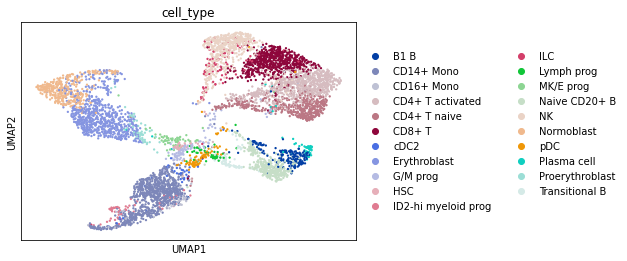

In [53]:
sc.pl.umap(atac, color = ["cell_type"])

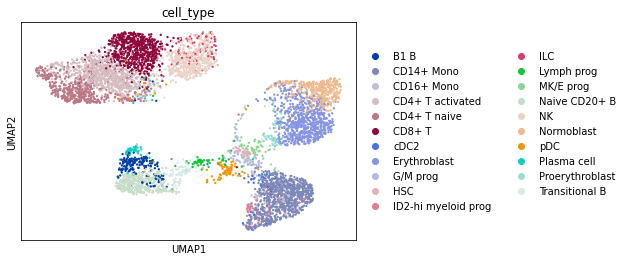

In [27]:
sc.pl.umap(atac, color = ["cell_type"])

In [43]:
model.save("/storage/groups/ml01/workspace/laura.martens/atac_poisson_data/models/poisson_atac_scvi_halved")

# PEAKVI

In [54]:
atac = adata[adata.obs.batch == 's1d1'].copy()

In [55]:
atac.layers["counts"].data = np.ceil(atac.layers["counts"].data/2)

In [56]:
atac.layers["counts"].max()

94.0

In [57]:
scvi.model.PEAKVI.setup_anndata(atac)

/storage/groups/ml01/code/laura.martens/github_repos/scvi-tools/scvi/data/anndata/_utils.py:97: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(


In [60]:
model = scvi.model.PEAKVI(adata=atac)

In [62]:
#setup logger
logger = WandbLogger(project=f"poisson_atac")
logger.watch(model.module, log='all')

#train model
model.train(logger=logger,train_size=0.8, validation_size=0.1, early_stopping=True)
wandb.finish()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 122/500:  24%|██▍       | 122/500 [20:58<1:04:58, 10.31s/it, loss=1.55e+08, v_num=zrss]


elbo_train,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
elbo_validation,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
kl_global_train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
kl_global_validation,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
kl_local_train,▁▅▆▆▅▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████
kl_local_validation,▁▄▆▆▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█████
reconstruction_loss_train,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss_validation,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▇▇▁▆▇▇▆▆▆▆▆▆▆▆▆▁▆▆▆▆▆▆▆▆▆▆▆▆▁▆▆▆▆▆▆▆▆▆▆


In [63]:
X_emb = model.get_latent_representation(atac)

In [64]:
compute_embedding(atac, X_emb)

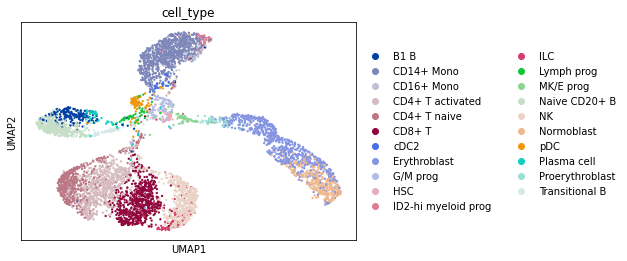

In [65]:
sc.pl.umap(atac, color = ["cell_type"])

# Own model

In [12]:
patac.model.CountPEAKVI.setup_anndata(atac, layer="counts", batch_key=None)

In [13]:
#model = patac.model.PEAKVI(adata, n_latent=130)
model = patac.model.CountPEAKVI(atac)

In [14]:
model.module

CountVAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=116490, out_features=341, bias=True)
          (1): None
          (2): LayerNorm((341,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=341, out_features=341, bias=True)
          (1): None
          (2): LayerNorm((341,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=341, out_features=18, bias=True)
    (var_encoder): Linear(in_features=341, out_features=18, bias=True)
  )
  (decoder): DecoderSCVI(
    (factor_regressor): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=18, out_fe

In [ ]:
#setup logger
#logger = WandbLogger(project=f"poisson_atac")
#logger.watch(model.module, log='all')
#logger=logger,
#train model
model.train(train_size=0.8, validation_size=0.1, early_stopping=True, batch_size=128, max_epochs =2)
#wandb.finish()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 1/2:   0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
X_emb = model.get_latent_representation()

In [21]:
evaluate_embedding(atac, X_emb)

NMI...
ARI...


,0
NMI_cluster/label,0.300446
ARI_cluster/label,0.166656
ASW_label,NaN
ASW_label/batch,NaN
PCR_batch,NaN
cell_cycle_conservation,NaN
isolated_label_F1,NaN
isolated_label_silhouette,NaN
graph_conn,NaN
kBET,NaN


In [38]:
model.save("/storage/groups/ml01/workspace/laura.martens/atac_poisson_data/models/poisson_atac_count_nlatent_40")

# Check seml

In [5]:
patac.seml.experiment_runner_atac_to_atac.ExprimentWrapper()

AttributeError: module 'poisson_atac.seml' has no attribute 'experiment_runner_atac_to_atac'

In [12]:
patac.model.PEAKVI.setup_anndata(atac, layer="counts")

In [14]:
model =  patac.model.PEAKVI.load( "/storage/groups/ml01/workspace/laura.martens/atac_poisson_data/models/poisson_atac_count", adata=atac)

In [32]:
X_emb = model.get_latent_representation(atac)

In [39]:
compute_embedding(atac, X_emb)

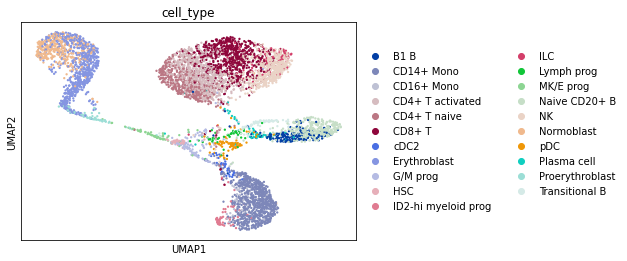

In [34]:
sc.pl.umap(atac, color = ["cell_type"])

In [22]:
model.module

CountVAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=116490, out_features=341, bias=True)
          (1): None
          (2): LayerNorm((341,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=341, out_features=341, bias=True)
          (1): None
          (2): LayerNorm((341,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=341, out_features=130, bias=True)
    (var_encoder): Linear(in_features=341, out_features=130, bias=True)
  )
  (decoder): LinearDecoderSCVI(
    (factor_regressor): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=13